# Introduction

This notebooks shows how to use Felis Cloud to benchmark the capabilities of Boson 4, Alice & Bob's first quantum chip on the cloud!

We will run experiments to characterize the performances of the cat-qubit operations. The user is given the following operations:

- Preparation of $|0\rangle$
- Preparation of $|1\rangle$
- Preparation of $|+\rangle$
- Measurement of Pauli operator $X$
- Measurement of Pauli operator $Z$
- Idling during an arbitrary time $t$
- $X(\pi)-$gate (purely virtual gate for cat qubits)
- $Z(\pi)-$gate

<img src="img/cat-blochsphere-01.png" style="width:50%">
<center> FIG 1: Definition of the Bloch sphere of the cat-qubit </center>

All these operations can be realized for various cat sizes, ranging from 4 to 10 photons.

The most important property of cat qubits is that bit-flip errors are exponentially suppressed with the number of photons. We verify this property in part 3 of the notebook, measuring bit-flip times above 1 second.

Interestingly, the physics behind the exponential suppression of bit-flip also allows to have exponentially precise state preparation and measurement (SPAM) of the observable Z. We will verify this property in part 4.

> Since cat qubits make so few bit-flips, measuring them can be difficult. As a consequence, we may need to average millions of times, to observe even a single bit-flip. So brace yourselves in such situations, because the measurements can last a bit.

<img src="img/cat-blochsphere-bf-pf.png" style="width:40%">
<center> FIG 2: A bit-flip correspond to a flip in between the south and north pole of the Bloch sphere. Bit-flips are exponentially suppressed in cat qubits. On the contrary, phase-flips (flip from one side of the equator to the other) increase linearly and must be corrected by an error correcting code, like the repetition code. </center>

Then, in part 5, we measure the phase-flip time, and verify that it increases only linearly with the number of photons.

Finally, in parts 6 and 7, we characterize the Z-gate. In particular, we verify that it is bias-preserving.

> The bit-flip time of cat qubits is many orders of magnitude larger than their phase-flip time. This property is coined **noise-bias**, and is what makes Quantum Error Correction of cat qubits so efficient. A crucial property of any operations performed on cat qubits is therefore that the operation preserve this noise bias. In this case, we say that the operation is **bias-preserving**. In part 7, we indeed verify that the Z-gate is bias-preserving.

> The fact that the operations must be bias-preserving also forbids to perform $X(\pi/2)$ and $Y(\pi/2)$ gates, since these convert a phase-flip into a bit-flip. That's why our physical gate-set is pretty limited and not universal at the physical level. However, reassure yourself, we can make a universal gate set at the logical level out of a non-universal gate set at the physical level. See our logical qubit emulator for more details!

# Helper functions

We start with a few import and helper functions that you can run blindly for the moment.

## Import and some functions

In [2]:
from matplotlib import pyplot as plt
import math
import numpy as np
import scipy as sp
from qiskit import QuantumCircuit, execute
from qiskit.providers import BackendV2
from time import sleep
import traceback

# set default plot parameters
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',

    'font.family': 'serif',
    'font.size': 16,

    'figure.dpi': 72.0,

    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 5.0,
    'xtick.minor.size': 2.5,
    'ytick.major.size': 5.0,
    'ytick.minor.size': 2.5,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,

    'axes.grid': True,
    'axes.titlesize': 'larger',
    'axes.labelsize': 'larger',
    'legend.fontsize': 'larger',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.alpha': 0.3,

    'lines.linewidth': 1.0,
    
    'figure.figsize': (16, 8)
})

In [3]:
def build_bit_flip_circuit(
    delay_duration_s: float, add_z: int = 0, add_x: bool = False
) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    if add_x:
        circ.initialize('1', 0)
    else:
        circ.initialize('0', 0)
    for _ in range(add_z):
        circ.z(0)
    if delay_duration_s > 0:
        circ.delay(delay_duration_s, 0, unit="s")
    circ.measure(0, 0)
    return circ

def build_phase_flip_circuit(
    delay_duration_s: float, cat_qubit_arch: bool, add_z: int = 0,
) -> QuantumCircuit:
    circ = QuantumCircuit(1, 1)
    if cat_qubit_arch:
        circ.initialize('+', 0)
    else:
        circ.h(0)
    for _ in range(add_z):
        circ.z(0)
    if delay_duration_s > 0:
        circ.delay(delay_duration_s, 0, unit='s')
    if cat_qubit_arch:
        circ.measure_x(0, 0)
    else:
        circ.h(0)
        circ.measure(0,0)
    return circ

def mean_std_X(counts: dict) -> tuple[float, float]:
    """
    Computes mean value and standard deviation of measurement of observable Pauli X
    """
    nb_shots = counts.get('0', 0) + counts.get('1', 0)
    p = counts.get('1',0) / nb_shots
    std = np.sqrt(p * (1 - p) / nb_shots)
    mean_X = 1 - 2 * p
    std_X = 2 * std
    return mean_X, std_X

def mean_std_Z(counts: dict) -> tuple[float, float]:
    """
    Computes mean value and standard deviation of measurement of observable Pauli Z
    """
    nb_shots = counts.get('0', 0) + counts.get('1', 0)
    p = counts.get('1',0) / nb_shots
    std = np.sqrt(p * (1 - p) / nb_shots)
    std = np.maximum(std, 3 / nb_shots)
    mean_X = 2 * p - 1
    std_X = 2 * std
    return mean_X, std_X

## Access Alice & Bob hardware with Felis Cloud

The functions below use the Alice & Bob provider, an open-source library maintained by Alice & Bob. 

We will use the provider to connect to the Boson 4, as well as to emulate cat qubits with performances similar to the Boson 4's.

In [4]:
from qiskit_alice_bob_provider import AliceBobRemoteProvider, AliceBobLocalProvider
from qiskit.providers import BackendV2
from qiskit.providers.fake_provider import FakeVigo


NB_PHOTONS_RANGE = [4.0, 6.0, 8.0, 10.0]


def create_boson_4_backend(average_nb_photons: float) -> BackendV2:
    ab_provider = AliceBobRemoteProvider(
        api_key="YOUR_API_KEY_HERE",
    )
    return ab_provider.get_backend(
        "QPU:1Q:BOSON_4A", average_nb_photons=average_nb_photons
    )


def create_theory_cat_backend(average_nb_photons: float) -> BackendV2:
    ab_provider = AliceBobLocalProvider()
    return ab_provider.get_backend(
        "EMU:6Q:PHYSICAL_CATS",
        average_nb_photons=average_nb_photons,
        kappa_1=2 * 3.14 * 2_260,
        kappa_2=2 * 3.14 * 250_000,
    )

## Access other architectures

Other manufacturers also provide an access to their emulators and hardware. We will be using the noisy emulator `FakeVigo`, developed by IBM, as an example comparison.

In [5]:
fake_vigo_backend = FakeVigo()

# Bit-flip lifetime: P0 | Idle | Mz

To measure the bit-flip time, we play the following pulse sequence:

- Prepare $\langle Z \rangle_0 = \pm 1$
- Wait for some variable time $t$
- Measure $\langle Z \rangle_t$

We then fit $\langle Z \rangle_t = \pm e^{-t/T_Z}$, where the decay time $T_Z$ of the Pauli observable $Z$ is the bit-flip time.

Repeating this measurement for several number of photons $\bar{n}$, we expect to see an exponential increase of the bit-flip time:

$$T_Z \propto e^{\gamma\bar{n}}$$

Where the scaling factor $\gamma \leq 2$ in presence of pure dephasing of the oscillator.

> Note: in this section, we completely neglect SPAM errors. This will be justified by the measurements of the next section.

## Circuit

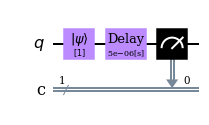

In [172]:
cat_circuit = build_bit_flip_circuit(delay_duration_s=5e-6, add_x=True)
cat_circuit.draw("mpl")

## Helpers

Helper functions to measure $\langle Z \rangle_t$, fit $T_Z$ and plot the result.

In [227]:
def measure_bitflip_time(nb_photons, time_range, shots):
    mean = np.zeros((time_range.size, 2), dtype=float)
    std = np.zeros_like(mean)
    backend = create_boson_4_backend(nb_photons)
    # backend = create_theory_cat_backend(nb_photons)
    for i, time in enumerate(time_range):
        for j, add_x in enumerate([True, False]):
            success = False
            while not success:
                try:
                    circuit = build_bit_flip_circuit(delay_duration_s=time, add_x=add_x)
                    counts = execute(circuit, backend, shots=shots).result().get_counts()
                    m, s = mean_std_Z(counts)
                    mean[i, j] = m
                    std[i, j] = s
                    print(f"nb_photons = {nb_photons} - time = {time} - add_x = {add_x} - <Z> = {mean[i, j]:.02e} +- {std[i, j]:.02e}")
                    success = True
                except Exception:
                    traceback.print_exc()
                    sleep(10)
    return mean, std

def fit_bitflip_time(time_range, mean, std):
    def fun(t, *p):
        T = p
        return np.exp(-t / T)
    x = time_range
    y = 0.5 * (mean[:, 0] - mean[:, 1])
    sigma = 0.5 * np.sqrt(std[:, 1]**2 + std[:, 0]**2)
    T_guess = -x[1] / np.log(y[1])
    p0 = [T_guess]
    popt, pcov = sp.optimize.curve_fit(fun, x, y, p0=p0, sigma=sigma, absolute_sigma=True)
    T_z = popt[0]
    T_z_std = np.sqrt(pcov[0,0])
    fit = fun(time_range, *popt)
    return fit, T_z, T_z_std

def plot_bitflip_time(time_range, mean, std, fit):
    plt.errorbar(time_range, mean[:, 0], yerr=std[:, 0], marker='x', markersize=8, capsize=5, linestyle='none', label='$P_0$')
    plt.errorbar(time_range, -mean[:, 1], yerr=std[:, 1], marker='x', markersize=8, capsize=5, linestyle='none', label='$P_1$')
    plt.plot(time_range, fit, label='Fit')
    plt.xlabel('Idle time (s)')
    plt.ylabel('abs(<Z>)')
    plt.legend()

## 4 photons

We start with the smaller number of photons, $\bar{n}=4$ photons. As can be seen below, the bit-flip time $T_Z=600$ us is already one order of magnitude large than the bare $T_1$ of the oscillator.

In [174]:
nb_photons = 4.0
time_range = np.linspace(0, 3e-3, 11)
shots = 500
mean, std = measure_bitflip_time(nb_photons, time_range, shots)

[09:33:31] Job 27a163cb-2bf1-4d5a-863f-ca4b50a1af28 finished successfully. Time spent executing on QPU: 876.00ms.
nb_photons = 4.0 - time = 0.0 - add_x = True - <Z> = 9.72e-01 +- 1.05e-02
[09:33:38] Job 262b1d32-cd6f-4d09-99dc-048da99bccf4 finished successfully. Time spent executing on QPU: 846.70ms.
nb_photons = 4.0 - time = 0.0 - add_x = False - <Z> = -9.84e-01 +- 7.97e-03
[09:33:47] Job 757e2d05-b425-4d0e-965c-6f2155550b8c finished successfully. Time spent executing on QPU: 1.19s.
nb_photons = 4.0 - time = 0.00030000000000000003 - add_x = True - <Z> = 6.04e-01 +- 3.56e-02
[09:33:54] Job 043a4a89-d062-49e0-a5ee-50a2e9c6f443 finished successfully. Time spent executing on QPU: 1.22s.
nb_photons = 4.0 - time = 0.00030000000000000003 - add_x = False - <Z> = -6.52e-01 +- 3.39e-02
[09:34:01] Job 7388d6a0-13f4-4ae8-9c48-c5c0507bd36c finished successfully. Time spent executing on QPU: 1.30s.
nb_photons = 4.0 - time = 0.0006000000000000001 - add_x = True - <Z> = 3.00e-01 +- 4.27e-02
[09:34:10

In [181]:
fit, T_z, T_z_std = fit_bitflip_time(time_range, mean, std)
print(f'{nb_photons} photons')
print(f'Bit-flip time: T_Z = ({T_z:.02e} +- {T_z_std:.02e}) s')

4.0 photons
Bit-flip time: T_Z = (5.99e-04 +- 2.47e-05) s


In [182]:
T_z_4_photons = T_z
T_z_std_4_photons = T_z_std

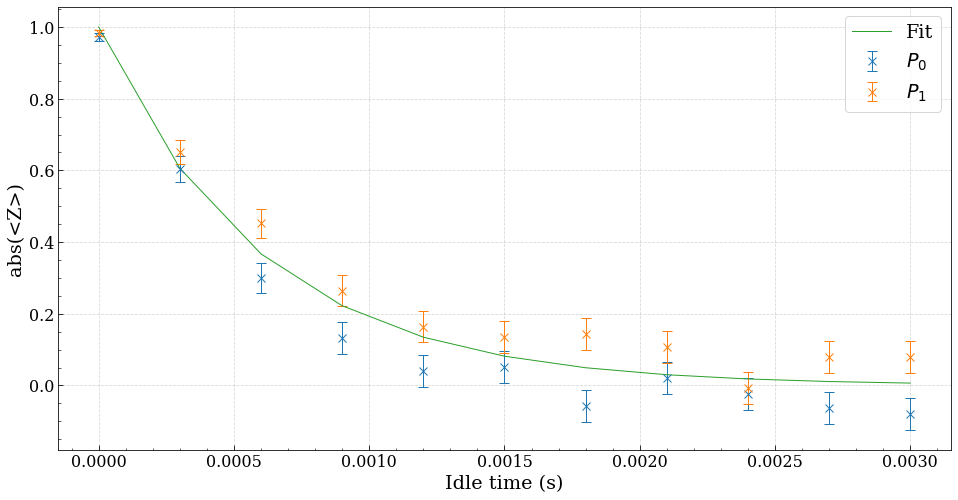

In [183]:
plot_bitflip_time(time_range, mean, std, fit)

## 7 photons

At $\bar{n}=7$ photons, the bit-flip time $T_Z$ increases to several tens of milliseconds. With such lifetimes, it becomes challenging to measure the complete decay of the exponential.

> Technical point: this is the main reason why we prepare both initial states $\langle Z \rangle_0 = -1$ and $\langle Z \rangle_0 = +1$. By taking the difference in between both curves, we remove any offset $\langle Z \rangle_{t\rightarrow\infty} \neq 0$ that may exist at long time and would lead to an incorrect estimation of $T_Z$.

In [221]:
nb_photons = 7.0
time_range = np.linspace(0, 50e-3, 11)
shots = 500
mean, std = measure_bitflip_time(nb_photons, time_range, shots)

[10:06:40] Job b93a5651-e079-4cf4-bfc1-be78a29fc197 finished successfully. Time spent executing on QPU: 732.19ms.
nb_photons = 7.0 - time = 0.0 - add_x = True - <Z> = 1.00e+00 +- 1.20e-02
[10:06:47] Job cce6bf8b-03a6-4716-9c0e-e44970d1f7d5 finished successfully. Time spent executing on QPU: 710.30ms.
nb_photons = 7.0 - time = 0.0 - add_x = False - <Z> = -1.00e+00 +- 1.20e-02
[10:06:56] Job b05e2267-5ce9-447f-89ed-0403f5663586 finished successfully. Time spent executing on QPU: 3.49s.
nb_photons = 7.0 - time = 0.005 - add_x = True - <Z> = 9.44e-01 +- 1.48e-02
[10:07:07] Job 223c59a4-1f9d-42bb-8581-49a2ad6d5690 finished successfully. Time spent executing on QPU: 3.63s.
nb_photons = 7.0 - time = 0.005 - add_x = False - <Z> = -9.48e-01 +- 1.42e-02
[10:07:20] Job 00b01151-df01-459b-94c1-31467c08e8ef finished successfully. Time spent executing on QPU: 6.17s.
nb_photons = 7.0 - time = 0.01 - add_x = True - <Z> = 8.52e-01 +- 2.34e-02
[10:07:35] Job ee415d1f-4784-4422-a53e-5bb92d2b37d6 finished

In [228]:
fit, T_z, T_z_std = fit_bitflip_time(time_range, mean, std)
print(f'{nb_photons} photons')
print(f'Bit-flip time: T_Z = ({T_z:.02e} +- {T_z_std:.02e}) s')

7.0 photons
Bit-flip time: T_Z = (7.38e-02 +- 2.19e-03) s


In [229]:
T_z_7_photons = T_z
T_z_std_7_photons = T_z_std

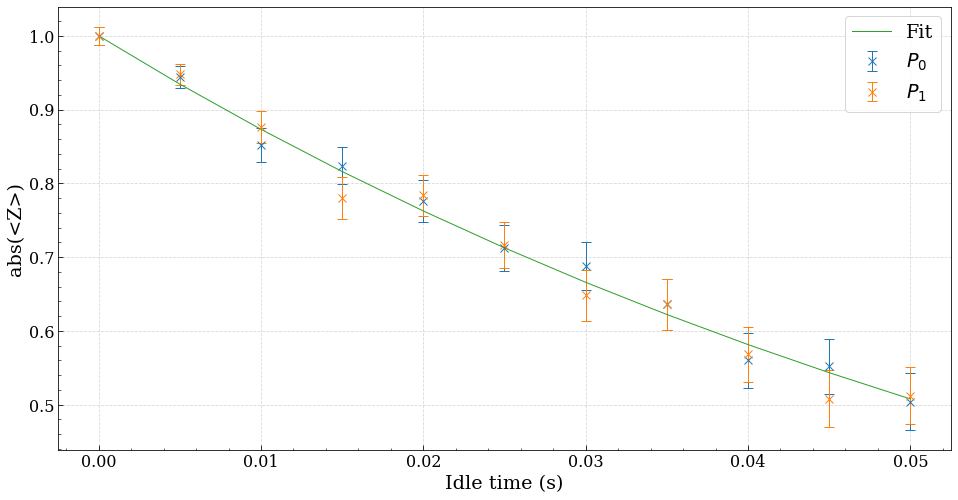

In [230]:
plot_bitflip_time(time_range, mean, std, fit)

## 10 photons

At $\bar{n}=10$ photons, the bit-flip time $T_Z$ increases to several tens of seconds. This is the maximum we can measure with the current readout technique in a reasonable amount of time.

> In Réglade, Bocquet et al., arXiv:2307.06617 (2023), we show a quantum trajectory method which allows to measure the bit-flip time virtually up to arbitrarily large values.

In [231]:
nb_photons = 10.0
time_range = np.linspace(0, 1.0, 11)
shots = 500
mean, std = measure_bitflip_time(nb_photons, time_range, shots)

[11:28:38] Job 4c4b8882-3fe0-43c2-93c0-a2a3ca6fff35 finished successfully. Time spent executing on QPU: 908.03ms.
nb_photons = 10.0 - time = 0.0 - add_x = True - <Z> = 1.00e+00 +- 1.20e-02
[11:29:03] Job a4d32ccb-a4b8-4152-b89b-c4d23b1b734b finished successfully. Time spent executing on QPU: 849.99ms.
nb_photons = 10.0 - time = 0.0 - add_x = False - <Z> = -1.00e+00 +- 1.20e-02
[11:30:28] Job 681f80fd-dd8a-416e-803b-a6225bc4857b finished successfully. Time spent executing on QPU: 51.15s.
nb_photons = 10.0 - time = 0.1 - add_x = True - <Z> = 1.00e+00 +- 1.20e-02
[11:31:52] Job 3375c04a-b552-43d7-9f72-69f32b80c965 finished successfully. Time spent executing on QPU: 51.01s.
nb_photons = 10.0 - time = 0.1 - add_x = False - <Z> = -9.96e-01 +- 1.20e-02
[11:34:03] Job 4367ce0a-1887-4985-91e1-e4824261b4d5 finished successfully. Time spent executing on QPU: 1.0min 41s.
nb_photons = 10.0 - time = 0.2 - add_x = True - <Z> = 9.96e-01 +- 1.20e-02
[11:36:15] Job 62ad2d6d-26f6-44ab-9fbf-7d6dae12fb84 f

In [232]:
fit, T_z, T_z_std = fit_bitflip_time(time_range, mean, std)
print(f'{nb_photons} photons')
print(f'Bit-flip time: T_Z = ({T_z:.02e} +- {T_z_std:.02e}) s')

10.0 photons
Bit-flip time: T_Z = (5.00e+01 +- 1.10e+01) s


In [233]:
T_z_10_photons = T_z
T_z_std_10_photons = T_z_std

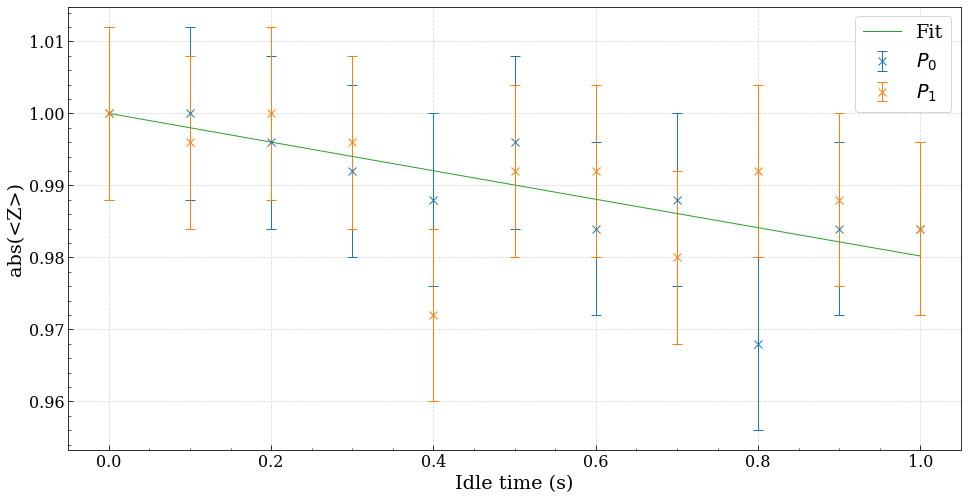

In [234]:
plot_bitflip_time(time_range, mean, std, fit)

## Scaling

Gathering the results of the previous sections, we plot the scaling of the bit-flip time $T_Z$ with $\bar{n}$ and fit it with an exponential function $\exp(\gamma \bar{n})$.

Thanks to this exponential scaling, bit-flips become quickly completely negligible. As a consequence, we can use a simple 1D repetition code tackling only phase-flips to realize a logical qubit. This leads to a massive reduction of the hardware overhead required for Quantum Error Correction (from x60 to x200).

In [235]:
nb_photons_range = np.array([4.0, 7.0, 10.0])
T_z = np.array([T_z_4_photons, T_z_7_photons, T_z_10_photons])
T_z_std = np.array([T_z_std_4_photons, T_z_std_7_photons, T_z_std_10_photons])

In [236]:
def fun(nbar, *p):
    T0, gamma = p
    return T0 * np.exp(gamma * nbar)
x = nb_photons_range
y = T_z
sigma = T_z_std
gamma_guess = np.log(y[0] / y[1]) / (x[0] - x[1])
T0_guess = y[0] / np.exp(gamma_guess * x[0])
p0 = [T0_guess, gamma_guess]
popt, pcov = sp.optimize.curve_fit(fun, x, y, p0=p0, sigma=sigma, absolute_sigma=True)

Text(0.5, 1.0, '$T_0=(0.96\\pm0.10)$ us - $\\gamma=(1.61\\pm0.02)$')

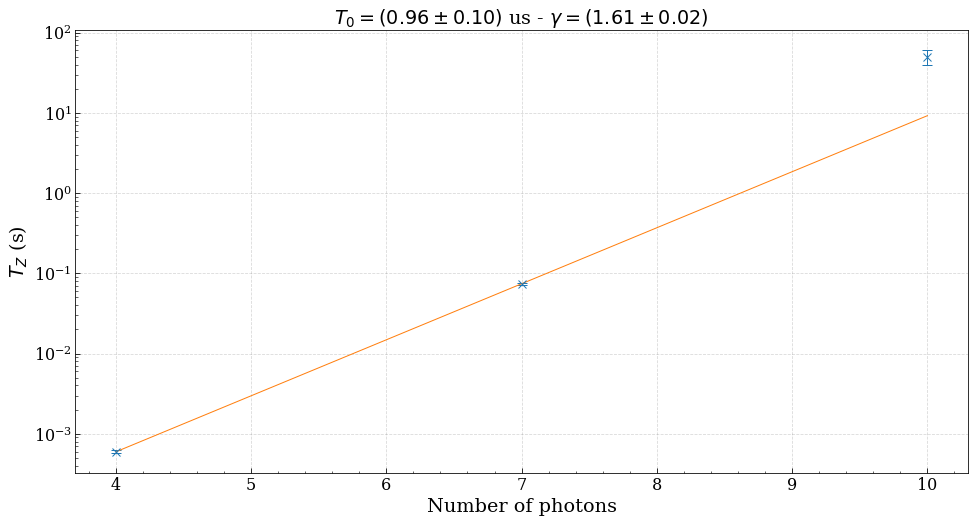

In [239]:
plt.errorbar(nb_photons_range, T_z, yerr=T_z_std, marker='x', markersize=8, capsize=5, linestyle='none')
plt.plot(nb_photons_range, fun(nb_photons_range, *popt))
plt.yscale('log')
plt.xlabel('Number of photons')
plt.ylabel('$T_Z$ (s)')
plt.title(f'$T_0=({popt[0]*1e6:.02f}\pm{np.sqrt(pcov[0,0])*1e6:.02f})$ us - $\gamma=({popt[1]:.02f}\pm{np.sqrt(pcov[1,1]):.02f})$')

# SPAM: P0 | Mz and P1 | Mz

The physics behind the exponential increase of the bit-flip time $T_Z$ also allows to have exponentially precise state preparation and measurement (SPAM) of the observable Z.

We verify it by playing the following pulse sequence:

- Prepare state $|0\rangle$
- Measure $Z$

Ideally, we would only measure $0$'s. By counting the number of $1$'s we get, that is the number of times the Pauli observable $Z$ flips, we extract the SPAM error probability:

$$\epsilon_Z = \frac{N_1}{N_0 + N_1}$$

We can do the same experiment starting from state $|1\rangle$, in which case:

$$\epsilon_Z = \frac{N_0}{N_0 + N_1}$$

As we will see, the SPAM errors are suppressed exponentially with the number of photons:

$$\epsilon_Z \propto e^{-\gamma\bar{n}}$$

This is really nice, but also makes challenging to measure even a single flip of the observable $Z$ at large photon number. The way we proceed below is to start with 1000 shots, and increase the number of shots by a factor 10x until we get at least 100 flips of the observable. Eventually, we stop at 10_000_000 shots, which is the hard limit of the Cloud API.

## Circuit

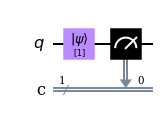

In [130]:
cat_circuit = build_bit_flip_circuit(delay_duration_s=0, add_x=True)
cat_circuit.draw("mpl")

## Scaling

In [131]:
nb_photons_range = np.array([4.0, 7.0, 10.0])
N_pos = np.zeros((nb_photons_range.size, 2), dtype=int)
N_tot = np.zeros_like(N_pos, dtype=int)
for j, add_x in enumerate([True, False]):
    N = 1000
    for i, nb_photons in enumerate(nb_photons_range):
        backend = create_boson_4_backend(nb_photons)
    #     backend = create_theory_cat_backend(nb_photons)
        enough_counts = False
        reached_limit = False
        while (not enough_counts) and (not reached_limit):
            success = False
            while not success:
                try:
                    circuit = build_bit_flip_circuit(delay_duration_s=0, add_x=add_x)
                    counts = execute(circuit, backend, shots=N).result().get_counts()
                    success = True
                except Exception:
                    traceback.print_exc()
                    sleep(10)
            N_pos[i, j] += counts.get('0', 0) if add_x else counts.get('1', 0)
            N_tot[i, j] += counts.get('0', 0) + counts.get('1', 0)
            print(f"nb_photons = {nb_photons} - add_x = {add_x} - N_pos = {N_pos[i, j]} - N_tot = {N_tot[i, j]}")
            if N_pos[i, j] > 100:
                enough_counts = True
            else:
                N *= 10
            if N > 10_000_000:
                reached_limit = True
                N = 10_000_000

[22:13:20] Job a967bb0c-2f8e-44ea-a97d-d0ffe745c416 finished successfully. Time spent executing on QPU: 815.55ms.
nb_photons = 4.0 - add_x = True - N_pos = 12 - N_tot = 1000
[22:13:27] Job c58460b2-2fbc-4aed-a3d5-29f53953d73a finished successfully. Time spent executing on QPU: 1.08s.
nb_photons = 4.0 - add_x = True - N_pos = 132 - N_tot = 11000
[22:13:29] Job 6faeda13-36b5-4cbd-9a14-6594edf63493 is being executed.                     


Traceback (most recent call last):
  File "C:\Users\sebas\AppData\Local\Temp\ipykernel_24296\3423848135.py", line 16, in <module>
    counts = execute(circuit, backend, shots=N).result().get_counts()
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 269, in get_counts
    exp = self._get_experiment(key)
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 397, in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
qiskit.exceptions.QiskitError: "job incurred error ,  [{'content': {'code': '500', 'message': 'An unexpected error happened'}}]"


[22:13:48] Job 150277b1-93b9-42bf-9ae4-2b59fb47f26e finished successfully. Time spent executing on QPU: 1.09s.
nb_photons = 7.0 - add_x = True - N_pos = 0 - N_tot = 10000
[22:13:57] Job 9caf7c31-9a16-4bf4-aac5-9ac22b5d55be finished successfully. Time spent executing on QPU: 4.03s.
nb_photons = 7.0 - add_x = True - N_pos = 9 - N_tot = 110000
[22:14:37] Job ebf9c0c4-0d2b-43cb-ae07-a78821b2d36d finished successfully. Time spent executing on QPU: 33.02s.
nb_photons = 7.0 - add_x = True - N_pos = 90 - N_tot = 1110000
[22:20:12] Job 46a440c8-dc5e-4592-9762-50d9eb76538f finished successfully. Time spent executing on QPU: 5.0min 22s.
nb_photons = 7.0 - add_x = True - N_pos = 1403 - N_tot = 11110000
[22:26:10] Job 20f99661-aa44-4bf2-bf6c-be73df53d153 finished successfully. Time spent executing on QPU: 5.0min 22s.
nb_photons = 10.0 - add_x = True - N_pos = 50 - N_tot = 10000000
[22:26:46] Job b3eecf58-02e8-4343-be58-0be3416eea92 finished successfully. Time spent executing on QPU: 938.89ms.
nb_ph

Text(0, 0.5, '$\\epsilon_Z(SPAM)$')

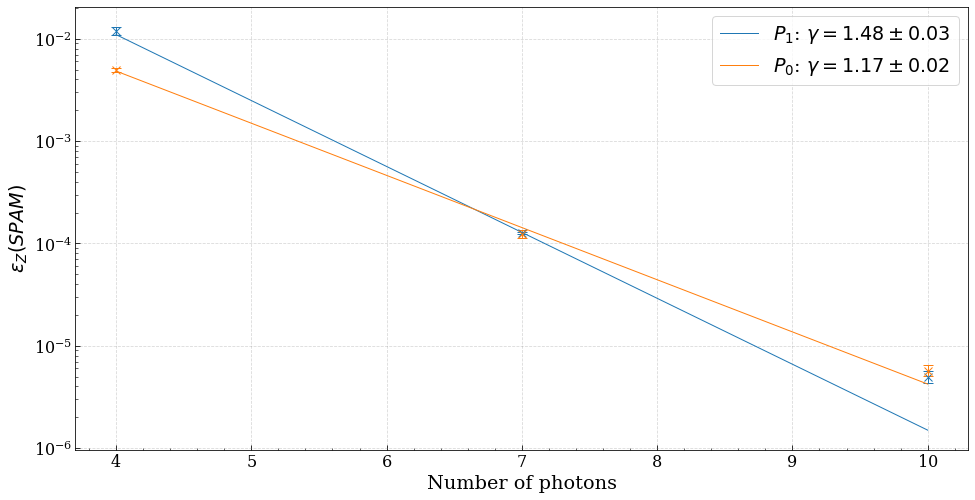

In [132]:
mean = N_pos / N_tot
std = np.maximum(np.sqrt(mean * (1 - mean) / N_tot), 3 / N_tot)
for i in range(2):
    plt.errorbar(
        nb_photons_range, mean[:, i], yerr=std[:, i], 
        marker='x', markersize=8, capsize=5, linestyle='none',
    )
plt.gca().set_prop_cycle(None)
for i in range(2):
    def fun(nbar, *p):
        A, gamma = p
        return A * np.exp(-gamma * nbar)
    x = nb_photons_range
    y = mean[:, i]
    sigma = std[:, i]
    gamma_guess = np.log(y[0] / y[1]) / (x[1] - x[0])
    A_guess = y[0] / np.exp(-gamma_guess * x[0])
    p0 = [A_guess, gamma_guess]
    popt, pcov = sp.optimize.curve_fit(fun, x, y, p0=p0, sigma=sigma, absolute_sigma=True)
    plt.plot(
        x, fun(x, *popt), 
        label=f'$P_{[1, 0][i]}$: $\gamma={popt[1]:.02f} \pm {np.sqrt(pcov[1,1]):.02f}$'
    )
plt.yscale('log')
plt.legend()
plt.xlabel('Number of photons')
plt.ylabel('$\epsilon_Z(SPAM)$')

# Phase-flip lifetime: P+ | Idle | Mx

To measure the phase-flip time, we play the following pulse sequence:

- Prepare $\langle X \rangle_0 = 1$
- Wait for some variable time $t$
- Measure $\langle X \rangle_t$

We then fit $\langle X \rangle_t = \langle X \rangle_0 e^{-t/T_X}$, where the decay time $T_X$ of the Pauli observable $X$ is the phase-flip time.

> Unlike for the observable $Z$, SPAM errors of the observable $X$ are sizeable. They are even quite large in this chip. This is owing to a not great $T_1\approx10$ us of the oscillator, and not-best-in-class two-photon dissipation rate $\kappa_2\approx 2\pi\times200$ kHz. As a consequence, we will keep $\langle X \rangle_0$ as a free fit parameter. The SPAM error probability is then given by: $\epsilon_X = 0.5\times\left(1 - \langle X \rangle_0\right)$.

Repeating this measurement for several number of photons $\bar{n}$, we expect to see a linear decrease of the phase-flip time:

$$T_X = \frac{T_1}{2\bar{n}}$$

Where $T_1$ is the energy relaxation time of the oscillator (plus some corrections due to finite temperature and non-linear Purcell rates).

## Circuit

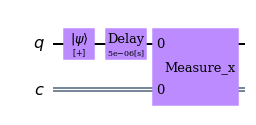

In [133]:
cat_circuit = build_phase_flip_circuit(
    delay_duration_s=5e-6, cat_qubit_arch=True
)
cat_circuit.draw("mpl")

## Helpers

Helper functions to measure $\langle X \rangle_t$, fit $T_X$ and plot the result.

In [134]:
def measure_phaseflip_time(nb_photons, time_range, shots):
    mean = np.zeros_like(time_range, dtype=float)
    std = np.zeros_like(mean)
    backend = create_boson_4_backend(nb_photons)
    # backend = create_theory_cat_backend(nb_photons)
    for i, time in enumerate(time_range):
        success = False
        while not success:
            try:
                circuit = build_phase_flip_circuit(delay_duration_s=time, cat_qubit_arch=True)
                counts = execute(circuit, backend, shots=shots).result().get_counts()
                m, s = mean_std_X(counts)
                mean[i] = m
                std[i] = s
                print(f"nb_photons = {nb_photons} - time = {time} - <X> = {mean[i]:.02e} +- {std[i]:.02e}")
                success = True
            except Exception:
                traceback.print_exc()
                sleep(10)
    return mean, std

def fit_phaseflip_time(time_range, mean, std):
    def fun(t, *p):
        C_spam, T, offset = p
        return C_spam * np.exp(-t / T) + offset
    x = time_range
    y = mean
    sigma = std
    offset_guess = y[-1]
    C_spam_guess = y[0] - offset_guess
    T_guess = -x[1] / np.log((y[1] - offset_guess) / C_spam_guess)
    p0 = [C_spam_guess, T_guess, offset_guess]
    popt, pcov = sp.optimize.curve_fit(fun, x, y, p0=p0, sigma=sigma, absolute_sigma=True)
    eps_x_spam = 0.5*(1-popt[0])
    eps_x_spam_std = 0.5 * np.sqrt(pcov[0,0])
    T_x = popt[1]
    T_x_std = np.sqrt(pcov[1,1])
    fit = fun(time_range, *popt)
    return fit, T_x, T_x_std, eps_x_spam, eps_x_spam_std

def plot_phaseflip_time(time_range, mean, std, fit):
    plt.errorbar(time_range * 1e6, mean, yerr=std, marker='x', markersize=8, capsize=5, linestyle='none')
    plt.plot(time_range * 1e6, fit)
    plt.xlabel('Idle time (us)')
    plt.ylabel('<X>')

## 4 photons

We start with the smaller number of photons, $\bar{n}=4$ photons. Given the large SPAM errors on this chip, we must average heavily: 100_000 shots.

In [135]:
nb_photons = 4.0
time_range = np.linspace(0, 5e-6, 21)
shots = 100_000
mean, std = measure_phaseflip_time(nb_photons, time_range, shots)

[22:37:40] Job f5d2012b-0e33-4c90-bed6-2c387ff428a5 finished successfully. Time spent executing on QPU: 4.48s.
nb_photons = 4.0 - time = 0.0 - <X> = 1.83e-01 +- 3.11e-03
[22:38:24] Job 84de38ff-e927-43b2-8476-b3a3708f6870 finished successfully. Time spent executing on QPU: 4.53s.
nb_photons = 4.0 - time = 2.5000000000000004e-07 - <X> = 1.41e-01 +- 3.13e-03
[22:39:07] Job 40120d65-58de-4058-96b7-89de61262fca finished successfully. Time spent executing on QPU: 4.56s.
nb_photons = 4.0 - time = 5.000000000000001e-07 - <X> = 1.16e-01 +- 3.14e-03
[22:39:33] Job b533e7e9-4f8a-4b01-aae1-e84f917eebb7 finished successfully. Time spent executing on QPU: 4.53s.
nb_photons = 4.0 - time = 7.500000000000001e-07 - <X> = 9.69e-02 +- 3.15e-03
[22:39:56] Job f9a564f4-97b4-453b-844b-abd49b44ed4b finished successfully. Time spent executing on QPU: 4.55s.
nb_photons = 4.0 - time = 1.0000000000000002e-06 - <X> = 8.42e-02 +- 3.15e-03
[22:40:17] Job 6216c43e-2cba-4ab7-8d2f-e7a3a7e8158f finished successfully. T

Traceback (most recent call last):
  File "C:\Users\sebas\AppData\Local\Temp\ipykernel_24296\1798398228.py", line 11, in measure_phaseflip_time
    counts = execute(circuit, backend, shots=shots).result().get_counts()
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 269, in get_counts
    exp = self._get_experiment(key)
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 397, in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
qiskit.exceptions.QiskitError: "job incurred error ,  [{'content': {'code': '500', 'message': 'An unexpected error happened'}}]"


[22:46:37] Job 0a104547-76bc-4b68-854f-9ec1ecf93262 finished successfully. Time spent executing on QPU: 5.06s.
nb_photons = 4.0 - time = 4.750000000000001e-06 - <X> = 4.47e-02 +- 3.16e-03
[22:46:43] Job ceb3cd4f-9e44-4a44-a802-0a6e4fdf6be6 is being executed.                     


Traceback (most recent call last):
  File "C:\Users\sebas\AppData\Local\Temp\ipykernel_24296\1798398228.py", line 11, in measure_phaseflip_time
    counts = execute(circuit, backend, shots=shots).result().get_counts()
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 269, in get_counts
    exp = self._get_experiment(key)
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 397, in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
qiskit.exceptions.QiskitError: "job incurred error ,  [{'content': {'code': '500', 'message': 'An unexpected error happened'}}]"


[22:47:00] Job 02f3913c-85f6-417e-985e-b60b1401079d is being executed.                     


Traceback (most recent call last):
  File "C:\Users\sebas\AppData\Local\Temp\ipykernel_24296\1798398228.py", line 11, in measure_phaseflip_time
    counts = execute(circuit, backend, shots=shots).result().get_counts()
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 269, in get_counts
    exp = self._get_experiment(key)
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 397, in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
qiskit.exceptions.QiskitError: "job incurred error ,  [{'content': {'code': '500', 'message': 'An unexpected error happened'}}]"


[22:47:19] Job fb274bec-85bf-49cc-a1eb-692cd135d9ff is being executed.                     


Traceback (most recent call last):
  File "C:\Users\sebas\AppData\Local\Temp\ipykernel_24296\1798398228.py", line 11, in measure_phaseflip_time
    counts = execute(circuit, backend, shots=shots).result().get_counts()
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 269, in get_counts
    exp = self._get_experiment(key)
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 397, in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
qiskit.exceptions.QiskitError: "job incurred error ,  [{'content': {'code': '500', 'message': 'An unexpected error happened'}}]"


[22:47:37] Job cf004bfe-d3e5-49ab-b5ba-cdb72195ff79 is being executed.                     


Traceback (most recent call last):
  File "C:\Users\sebas\AppData\Local\Temp\ipykernel_24296\1798398228.py", line 11, in measure_phaseflip_time
    counts = execute(circuit, backend, shots=shots).result().get_counts()
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 269, in get_counts
    exp = self._get_experiment(key)
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 397, in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
qiskit.exceptions.QiskitError: "job incurred error ,  [{'content': {'code': '500', 'message': 'An unexpected error happened'}}]"


[22:48:06] Job f3974e6e-bdfe-4889-8c22-121cddca6c8e finished successfully. Time spent executing on QPU: 5.12s.
nb_photons = 4.0 - time = 5e-06 - <X> = 4.75e-02 +- 3.16e-03


In [136]:
fit, T_x, T_x_std, eps_x_spam, eps_x_spam_std = fit_phaseflip_time(time_range, mean, std)
print(f'{nb_photons} photons')
print(f'Phase-flip time: T_X = ({T_x*1e6:.02f} +- {T_x_std*1e6:.02f}) us')
print(f'SPAM: epsilon_X = ({eps_x_spam*100:.01f} +- {eps_x_spam_std*100:.01f}) %')

4.0 photons
Phase-flip time: T_X = (0.82 +- 0.03) us
SPAM: epsilon_X = (42.8 +- 0.1) %


In [137]:
T_x_4_photons = T_x
T_x_std_4_photons = T_x_std
eps_x_spam_4_photons = eps_x_spam
eps_x_spam_std_4_photons = eps_x_spam_std

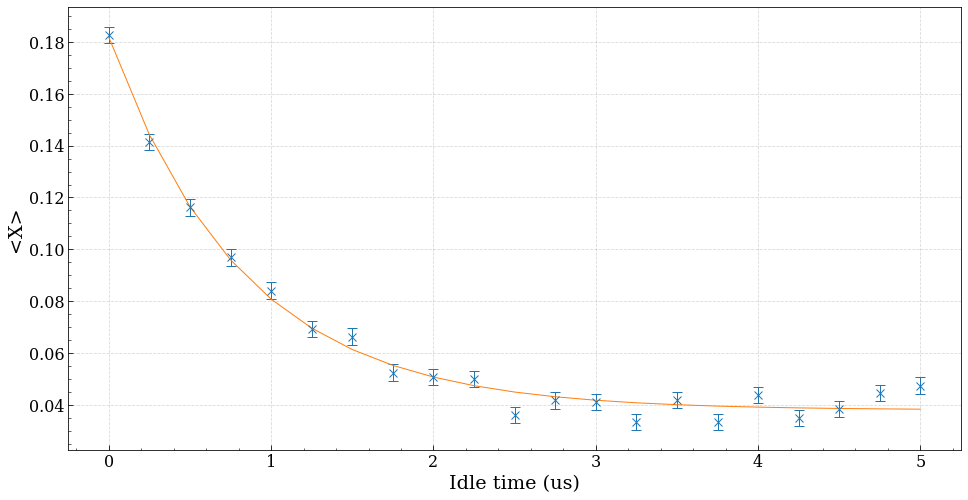

In [138]:
plot_phaseflip_time(time_range, mean, std, fit)

## 7 photons

In [139]:
nb_photons = 7.0
time_range = np.linspace(0, 2.5e-6, 21)
shots = 100_000
mean, std = measure_phaseflip_time(nb_photons, time_range, shots)

[22:48:20] Job acaed1dc-8375-4185-844c-e34d4b3b5ce7 finished successfully. Time spent executing on QPU: 4.37s.
nb_photons = 7.0 - time = 0.0 - <X> = 7.25e-02 +- 3.15e-03
[22:48:53] Job 2fc98545-b133-471c-a4e9-f50a3957202b finished successfully. Time spent executing on QPU: 4.41s.
nb_photons = 7.0 - time = 1.2500000000000002e-07 - <X> = 6.07e-02 +- 3.16e-03
[22:49:25] Job 3a67d860-405b-4055-bc3b-2c47e84f5d2d finished successfully. Time spent executing on QPU: 4.54s.
nb_photons = 7.0 - time = 2.5000000000000004e-07 - <X> = 4.64e-02 +- 3.16e-03
[22:49:58] Job 57f73bef-43ed-42ec-9c25-32708e02cc4d finished successfully. Time spent executing on QPU: 4.48s.
nb_photons = 7.0 - time = 3.7500000000000006e-07 - <X> = 2.93e-02 +- 3.16e-03
[22:50:29] Job 5a0db749-8019-41dc-9a1e-f13c761d733b finished successfully. Time spent executing on QPU: 4.45s.
nb_photons = 7.0 - time = 5.000000000000001e-07 - <X> = 3.51e-02 +- 3.16e-03
[22:51:05] Job af316525-3f09-492a-9b8c-dba33915287a finished successfully. 

In [140]:
fit, T_x, T_x_std, eps_x_spam, eps_x_spam_std = fit_phaseflip_time(time_range, mean, std)
print(f'{nb_photons} photons')
print(f'Phase-flip time: T_X = ({T_x*1e6:.02f} +- {T_x_std*1e6:.02f}) us')
print(f'SPAM: epsilon_X = ({eps_x_spam*100:.01f} +- {eps_x_spam_std*100:.01f}) %')

7.0 photons
Phase-flip time: T_X = (0.49 +- 0.04) us
SPAM: epsilon_X = (46.4 +- 0.1) %


In [141]:
T_x_7_photons = T_x
T_x_std_7_photons = T_x_std
eps_x_spam_7_photons = eps_x_spam
eps_x_spam_std_7_photons = eps_x_spam_std

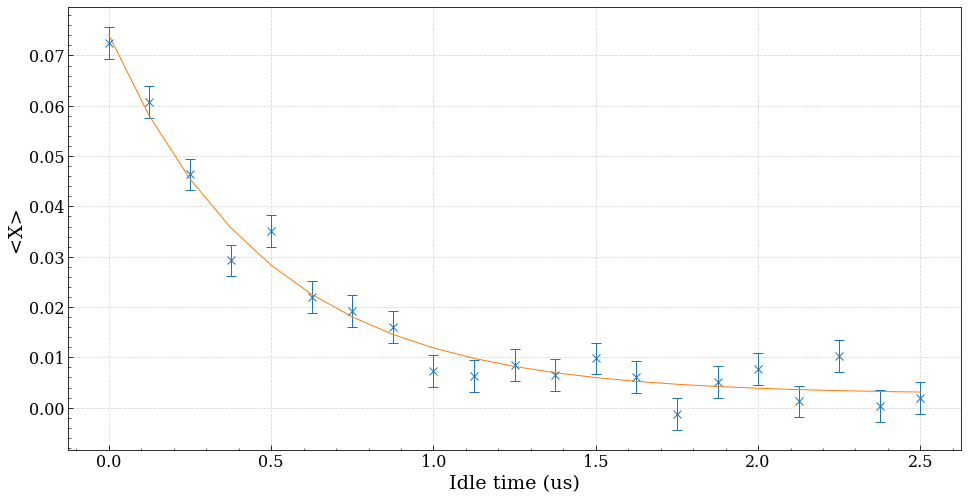

In [142]:
plot_phaseflip_time(time_range, mean, std, fit)

## 10 photons

SPAM errors increase with photon number and we must increase the averaging to have acceptable error bars: 200_000 shots.

In [143]:
nb_photons = 10.0
time_range = np.linspace(0, 1.8e-6, 21)
shots = 200_000
mean, std = measure_phaseflip_time(nb_photons, time_range, shots)

[22:55:24] Job 846fe077-5f1c-464c-8032-0b08ef114a41 finished successfully. Time spent executing on QPU: 7.78s.
nb_photons = 10.0 - time = 0.0 - <X> = 3.68e-02 +- 2.23e-03
[22:55:44] Job 042b3d5d-23d6-49d5-8117-653725e170a3 finished successfully. Time spent executing on QPU: 7.93s.
nb_photons = 10.0 - time = 9e-08 - <X> = 3.28e-02 +- 2.23e-03
[22:56:03] Job 6fe753f3-bf0b-45e9-8253-4193b0a314cd finished successfully. Time spent executing on QPU: 7.92s.
nb_photons = 10.0 - time = 1.8e-07 - <X> = 2.51e-02 +- 2.24e-03
[22:56:20] Job 5fe60253-234a-4a5c-892d-b0500cb126d1 finished successfully. Time spent executing on QPU: 7.94s.
nb_photons = 10.0 - time = 2.7e-07 - <X> = 1.98e-02 +- 2.24e-03
[22:56:37] Job 9261b90d-d142-468e-a0f4-eed9a866d75e finished successfully. Time spent executing on QPU: 7.88s.
nb_photons = 10.0 - time = 3.6e-07 - <X> = 1.72e-02 +- 2.24e-03
[22:56:54] Job bd378e40-1f94-4d29-b40c-b02f8f15dbfe finished successfully. Time spent executing on QPU: 7.90s.
nb_photons = 10.0 - 

In [144]:
fit, T_x, T_x_std, eps_x_spam, eps_x_spam_std = fit_phaseflip_time(time_range, mean, std)
print(f'{nb_photons} photons')
print(f'Phase-flip time: T_X = ({T_x*1e6:.02f} +- {T_x_std*1e6:.02f}) us')
print(f'SPAM: epsilon_X = ({eps_x_spam*100:.01f} +- {eps_x_spam_std*100:.01f}) %')

10.0 photons
Phase-flip time: T_X = (0.41 +- 0.05) us
SPAM: epsilon_X = (48.1 +- 0.1) %


In [145]:
T_x_10_photons = T_x
T_x_std_10_photons = T_x_std
eps_x_spam_10_photons = eps_x_spam
eps_x_spam_std_10_photons = eps_x_spam_std

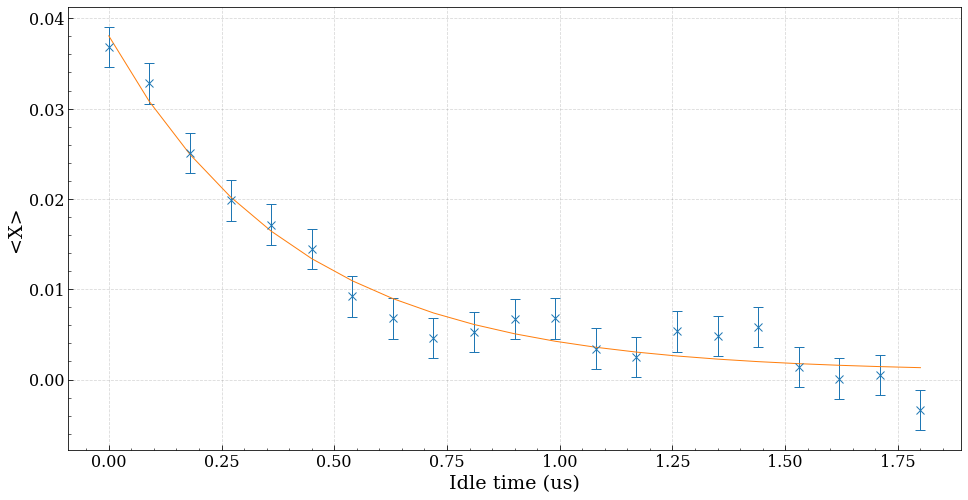

In [146]:
plot_phaseflip_time(time_range, mean, std, fit)

## Scaling

Gathering the results of the previous sections, we plot the linear scaling of the phase-flip time $T_X$ with $\bar{n}$ and fit it to extract the effective $T_1$ of the oscillator.

In [147]:
nb_photons_range = np.array([4.0, 7.0, 10.0])
T_x = np.array([T_x_4_photons, T_x_7_photons, T_x_10_photons])
T_x_std = np.array([T_x_std_4_photons, T_x_std_7_photons, T_x_std_10_photons])
Gamma_x = 1 / T_x
Gamma_x_std = T_x_std / T_x**2
eps_x_spam = np.array([eps_x_spam_4_photons, eps_x_spam_7_photons, eps_x_spam_10_photons])
eps_x_spam_std = np.array([eps_x_spam_std_4_photons, eps_x_spam_std_7_photons, eps_x_spam_std_10_photons])

In [148]:
def fun(nbar, *p):
    T1 = p
    return 2 * nbar / T1
x = nb_photons_range
y = Gamma_x
sigma = Gamma_x_std
p0 = [1 / np.mean(y / (2 * x))]
popt, pcov = sp.optimize.curve_fit(fun, x, y, p0=p0, sigma=sigma, absolute_sigma=True)

Text(0.5, 1.0, '$T_1=(6.82\\pm0.24)$ us')

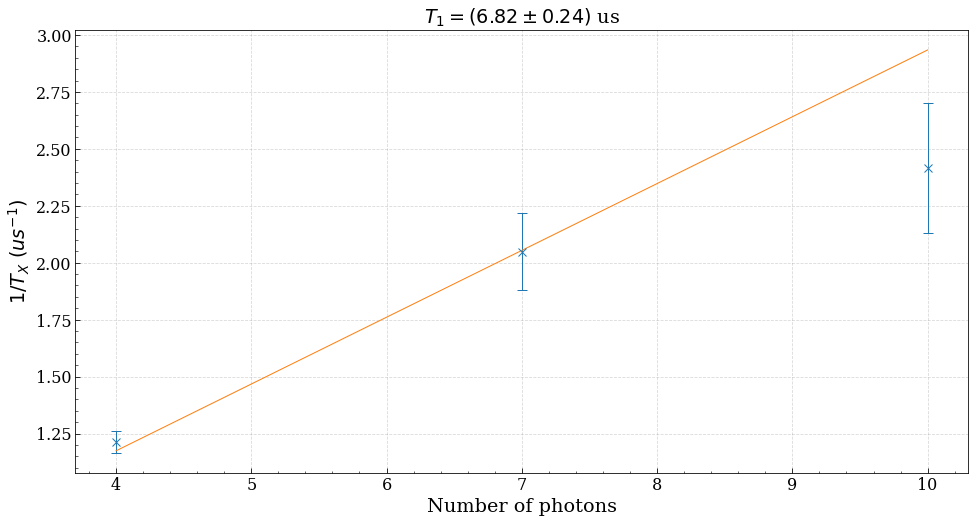

In [149]:
plt.errorbar(nb_photons_range, Gamma_x * 1e-6, yerr=Gamma_x_std * 1e-6, marker='x', markersize=8, capsize=5, linestyle='none')
plt.plot(nb_photons_range, fun(nb_photons_range, *popt) * 1e-6)
plt.xlabel('Number of photons')
plt.ylabel('$1 / T_X$ $(us^{-1})$')
plt.title(f'$T_1=({popt[0]*1e6:.02f}\pm{np.sqrt(pcov[0,0])*1e6:.02f})$ us')

Text(0, 0.5, '$\\epsilon_X(SPAM)$')

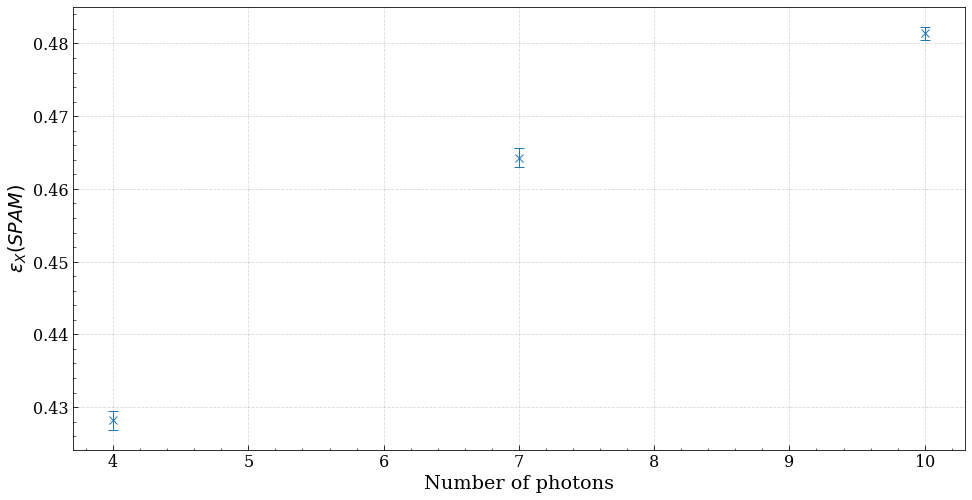

In [150]:
plt.errorbar(nb_photons_range, eps_x_spam, yerr=eps_x_spam_std, marker='x', markersize=8, capsize=5, linestyle='none')
plt.xlabel('Number of photons')
plt.ylabel('$\epsilon_X(SPAM)$')

# Z-gate phase-flip: P+ | Z^n | Mx

To characterize the Z-gate, we play the following pulse sequence:

- Prepare $\langle X \rangle_0 = 1$
- Play a number $n$ of Z-gate
- Measure $\langle X \rangle_n$

We then fit $\langle X \rangle_n = \langle X \rangle_0 (-C_X)^n$, where $C_X$ is the loss of contrast of the Pauli observable $X$ per Z-gate. The phase-flip error probability per Z-gate is then given by:

$$\epsilon_X = \frac{1 - C_X}{2}$$

Note that for the same reasons that SPAM errors of the observable $X$ are not good, phase-flip errors per Z-gate are not expected to be good either on this chip.

## Circuit

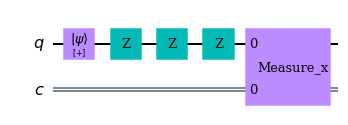

In [151]:
cat_circuit = build_phase_flip_circuit(delay_duration_s=0, cat_qubit_arch=True, add_z=3)
cat_circuit.draw('mpl')

## Helpers

Helper functions to measure $\langle X \rangle_n$, fit $\epsilon_X$ and plot the result.

In [152]:
def measure_phaseflip_Zgate(nb_photons, nb_gates_range, shots):
    mean = np.zeros_like(nb_gates_range, dtype=float)
    std = np.zeros_like(mean)
    backend = create_boson_4_backend(nb_photons)
    # backend = create_theory_cat_backend(nb_photons)
    for i, nb_gates in enumerate(nb_gates_range):
        success = False
        while not success:
            try:
                circuit = build_phase_flip_circuit(delay_duration_s=0, cat_qubit_arch=True, add_z=nb_gates)
                counts = execute(circuit, backend, shots=shots).result().get_counts()
                m, s = mean_std_X(counts)
                mean[i] = m
                std[i] = s
                print(f"nb_photons = {nb_photons} - nb_gates = {nb_gates} - <X> = {mean[i]:.02e} +- {std[i]:.02e}")
                success = True
            except Exception:
                traceback.print_exc()
                sleep(10)
    return mean, std

def fit_phaseflip_Zgate(nb_gates_range, mean, std):
    def fun(n, *p):
        C_spam, C_Zgate, offset = p
        return C_spam * (-C_Zgate)**n + offset
    x = nb_gates_range
    y = mean
    sigma = std
    offset_guess = y[-1]
    C_spam_guess = y[0] - offset_guess
    C_Zgate_guess = -(y[1] - offset_guess) / C_spam_guess
    p0 = [C_spam_guess, C_Zgate_guess, offset_guess]
    popt, pcov = sp.optimize.curve_fit(fun, x, y, p0=p0, sigma=sigma, absolute_sigma=True)
    eps_x_spam = 0.5*(1-popt[0])
    eps_x_spam_std = 0.5 * np.sqrt(pcov[0,0])
    eps_x_Zgate = 0.5*(1-popt[1])
    eps_x_Zgate_std = 0.5 * np.sqrt(pcov[1,1])
    fit = fun(nb_gates_range, *popt)
    return fit, eps_x_Zgate, eps_x_Zgate_std, eps_x_spam, eps_x_spam_std

def plot_phaseflip_Zgate(nb_gates_range, mean, std, fit):
    plt.errorbar(nb_gates_range, mean, yerr=std, marker='x', markersize=8, capsize=5, linestyle='none')
    plt.plot(nb_gates_range[::2], fit[::2])
    plt.plot(nb_gates_range[1::2], fit[1::2])
    plt.xlabel('Number of gates')
    plt.ylabel('<X>')

## 4 photons

We start with the smaller number of photons, $\bar{n}=4$ photons. Given the large SPAM errors on this chip, we must average heavily: 100_000 shots.

In [153]:
nb_photons = 4.0
nb_gates_range = np.arange(20, dtype=int)
shots = 100_000
mean, std = measure_phaseflip_Zgate(nb_photons, nb_gates_range, shots)

[23:03:54] Job 6f8cf1b4-2470-4503-9e44-a8503609900e finished successfully. Time spent executing on QPU: 4.37s.
nb_photons = 4.0 - nb_gates = 0 - <X> = 1.96e-01 +- 3.10e-03
[23:04:07] Job 99096dc3-6354-48eb-a03a-05e25353faf2 finished successfully. Time spent executing on QPU: 4.54s.
nb_photons = 4.0 - nb_gates = 1 - <X> = -3.72e-02 +- 3.16e-03
[23:04:20] Job 85505ca8-8bbc-4528-a460-16dc45c123bd finished successfully. Time spent executing on QPU: 4.58s.
nb_photons = 4.0 - nb_gates = 2 - <X> = 1.17e-01 +- 3.14e-03
[23:04:33] Job 40f7f109-34a8-42fc-8fa0-1e1829d4f79c finished successfully. Time spent executing on QPU: 4.42s.
nb_photons = 4.0 - nb_gates = 3 - <X> = 2.40e-02 +- 3.16e-03
[23:04:54] Job 7b94e0d4-e0fa-4fa6-b35d-aaa49603126b finished successfully. Time spent executing on QPU: 4.48s.
nb_photons = 4.0 - nb_gates = 4 - <X> = 8.20e-02 +- 3.15e-03
[23:05:09] Job 8b6f8f08-d60b-4694-901d-8ab1768baab8 finished successfully. Time spent executing on QPU: 4.61s.
nb_photons = 4.0 - nb_gates 

In [154]:
fit, eps_x_Zgate, eps_x_Zgate_std, eps_x_spam, eps_x_spam_std = fit_phaseflip_Zgate(nb_gates_range, mean, std)
print(f'{nb_photons} photons')
print(f'Z-gate: epsilon_X = ({eps_x_Zgate*100:.01f} +- {eps_x_Zgate_std*100:.01f}) %')
print(f'SPAM: epsilon_X = ({eps_x_spam*100:.01f} +- {eps_x_spam_std*100:.01f}) %')

4.0 photons
Z-gate: epsilon_X = (18.3 +- 0.5) %
SPAM: epsilon_X = (42.8 +- 0.1) %


In [155]:
eps_x_Zgate_4_photons = eps_x_Zgate
eps_x_Zgate_std_4_photons = eps_x_Zgate_std
eps_x_spam_4_photons = eps_x_spam
eps_x_spam_std_4_photons = eps_x_spam_std

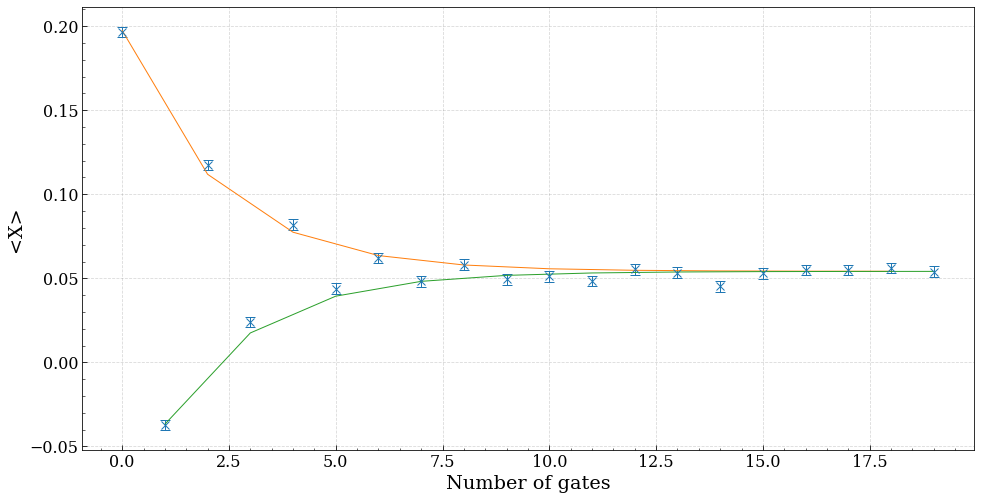

In [156]:
plot_phaseflip_Zgate(nb_gates_range, mean, std, fit)

## 7 photons

SPAM and Z-gate errors increase with photon number and we must increase the averaging to have acceptable error bars: 200_000 shots.

In [157]:
nb_photons = 7.0
nb_gates_range = np.arange(10, dtype=int)
shots = 200_000
mean, std = measure_phaseflip_Zgate(nb_photons, nb_gates_range, shots)

[23:12:22] Job 80fdc2d6-91a5-43fb-8f5d-e0803c5cea8d finished successfully. Time spent executing on QPU: 7.88s.
nb_photons = 7.0 - nb_gates = 0 - <X> = 6.55e-02 +- 2.23e-03
[23:12:39] Job f06f18eb-cf67-4ec8-acca-7055da36ef6b finished successfully. Time spent executing on QPU: 7.96s.
nb_photons = 7.0 - nb_gates = 1 - <X> = -4.51e-02 +- 2.23e-03
[23:12:56] Job ecdc90f3-9c39-4bbb-8803-cd5913af8ab0 finished successfully. Time spent executing on QPU: 8.02s.
nb_photons = 7.0 - nb_gates = 2 - <X> = 3.50e-02 +- 2.23e-03
[23:13:13] Job b4b47974-03e3-44db-bb71-60537bb20299 finished successfully. Time spent executing on QPU: 7.97s.
nb_photons = 7.0 - nb_gates = 3 - <X> = -1.91e-02 +- 2.24e-03
[23:13:35] Job 5f4911df-6284-4551-9250-4ba033a5ac24 finished successfully. Time spent executing on QPU: 8.00s.
nb_photons = 7.0 - nb_gates = 4 - <X> = 1.88e-02 +- 2.24e-03
[23:13:56] Job 45be76b8-40f9-4c5e-8b3f-3f7dfa009d7b finished successfully. Time spent executing on QPU: 8.04s.
nb_photons = 7.0 - nb_gates

Traceback (most recent call last):
  File "C:\Users\sebas\AppData\Local\Temp\ipykernel_24296\2275136710.py", line 11, in measure_phaseflip_Zgate
    counts = execute(circuit, backend, shots=shots).result().get_counts()
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 269, in get_counts
    exp = self._get_experiment(key)
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 397, in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
qiskit.exceptions.QiskitError: "job incurred error ,  [{'content': {'code': '500', 'message': 'An unexpected error happened'}}]"


[23:15:05] Job 9a88a0e5-655f-42a1-b77c-3ced4429e984 finished successfully. Time spent executing on QPU: 8.11s.
nb_photons = 7.0 - nb_gates = 7 - <X> = -1.91e-03 +- 2.24e-03
[23:15:26] Job 62cbf604-dd4b-41d3-a843-d8ee5eaada35 finished successfully. Time spent executing on QPU: 8.05s.
nb_photons = 7.0 - nb_gates = 8 - <X> = 1.03e-02 +- 2.24e-03
[23:15:37] Job 6873aa24-6590-4abe-b34c-cb1533221d6c is being executed.                     


Traceback (most recent call last):
  File "C:\Users\sebas\AppData\Local\Temp\ipykernel_24296\2275136710.py", line 11, in measure_phaseflip_Zgate
    counts = execute(circuit, backend, shots=shots).result().get_counts()
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 269, in get_counts
    exp = self._get_experiment(key)
  File "C:\Users\sebas\anaconda3\lib\site-packages\qiskit\result\result.py", line 397, in _get_experiment
    raise QiskitError(result_status, ", ", exp_status)
qiskit.exceptions.QiskitError: "job incurred error ,  [{'content': {'code': '500', 'message': 'An unexpected error happened'}}]"


[23:16:10] Job fcfeed71-7bde-4387-a680-faf9b9e1171e finished successfully. Time spent executing on QPU: 8.20s.
nb_photons = 7.0 - nb_gates = 9 - <X> = -6.60e-04 +- 2.24e-03


In [158]:
fit, eps_x_Zgate, eps_x_Zgate_std, eps_x_spam, eps_x_spam_std = fit_phaseflip_Zgate(nb_gates_range, mean, std)
print(f'{nb_photons} photons')
print(f'Z-gate: epsilon_X = ({eps_x_Zgate*100:.01f} +- {eps_x_Zgate_std*100:.01f}) %')
print(f'SPAM: epsilon_X = ({eps_x_spam*100:.01f} +- {eps_x_spam_std*100:.01f}) %')

7.0 photons
Z-gate: epsilon_X = (14.9 +- 0.7) %
SPAM: epsilon_X = (46.8 +- 0.1) %


In [159]:
eps_x_Zgate_7_photons = eps_x_Zgate
eps_x_Zgate_std_7_photons = eps_x_Zgate_std
eps_x_spam_7_photons = eps_x_spam
eps_x_spam_std_7_photons = eps_x_spam_std

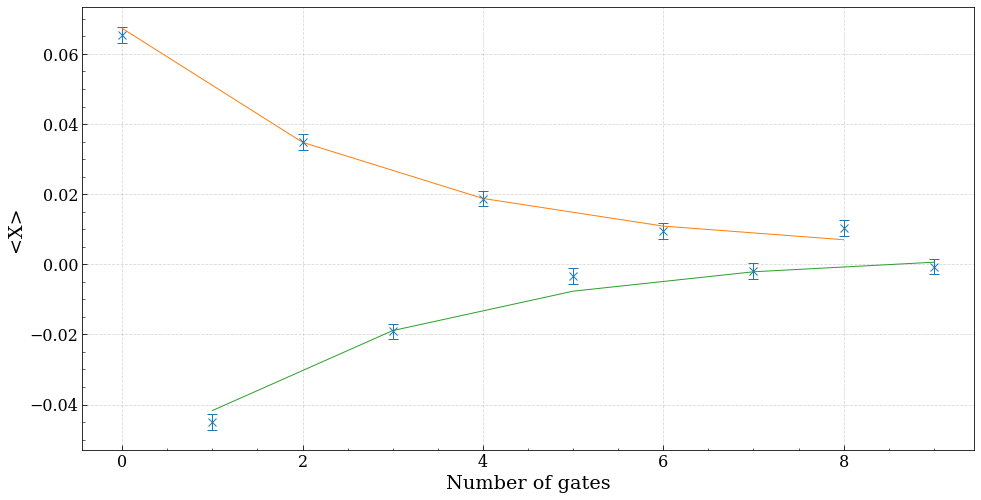

In [160]:
plot_phaseflip_Zgate(nb_gates_range, mean, std, fit)

## 10 photons

SPAM and Z-gate errors increase with photon number and we must increase again the averaging to have acceptable error bars: 400_000 shots.

In [161]:
nb_photons = 10.0
nb_gates_range = np.arange(10, dtype=int)
shots = 400_000
mean, std = measure_phaseflip_Zgate(nb_photons, nb_gates_range, shots)

[23:16:42] Job 19028f66-7e6a-4632-b2db-5f3679ac2b35 finished successfully. Time spent executing on QPU: 14.72s.
nb_photons = 10.0 - nb_gates = 0 - <X> = 3.53e-02 +- 1.58e-03
[23:17:05] Job 9dc45b61-cdf6-4468-98ba-4329bb8aa1b2 finished successfully. Time spent executing on QPU: 14.74s.
nb_photons = 10.0 - nb_gates = 1 - <X> = -1.64e-02 +- 1.58e-03
[23:17:28] Job fce93fb0-0ac6-4b61-b98c-fbf77c452227 finished successfully. Time spent executing on QPU: 14.81s.
nb_photons = 10.0 - nb_gates = 2 - <X> = 2.94e-03 +- 1.58e-03
[23:17:56] Job efffe8c1-14c9-4e78-ae43-ae7709a7fa8f finished successfully. Time spent executing on QPU: 14.82s.
nb_photons = 10.0 - nb_gates = 3 - <X> = 7.25e-04 +- 1.58e-03
[23:18:21] Job 26a5f559-49d2-4cbb-9852-07b36c81dda8 finished successfully. Time spent executing on QPU: 14.85s.
nb_photons = 10.0 - nb_gates = 4 - <X> = -6.00e-04 +- 1.58e-03
[23:18:48] Job 49b23374-3d0a-41d2-80c4-281dd54df771 finished successfully. Time spent executing on QPU: 14.91s.
nb_photons = 10.

In [162]:
fit, eps_x_Zgate, eps_x_Zgate_std, eps_x_spam, eps_x_spam_std = fit_phaseflip_Zgate(nb_gates_range, mean, std)
print(f'{nb_photons} photons')
print(f'Z-gate: epsilon_X = ({eps_x_Zgate*100:.01f} +- {eps_x_Zgate_std*100:.01f}) %')
print(f'SPAM: epsilon_X = ({eps_x_spam*100:.01f} +- {eps_x_spam_std*100:.01f}) %')

10.0 photons
Z-gate: epsilon_X = (29.8 +- 1.9) %
SPAM: epsilon_X = (48.3 +- 0.1) %


In [163]:
eps_x_Zgate_10_photons = eps_x_Zgate
eps_x_Zgate_std_10_photons = eps_x_Zgate_std
eps_x_spam_10_photons = eps_x_spam
eps_x_spam_std_10_photons = eps_x_spam_std

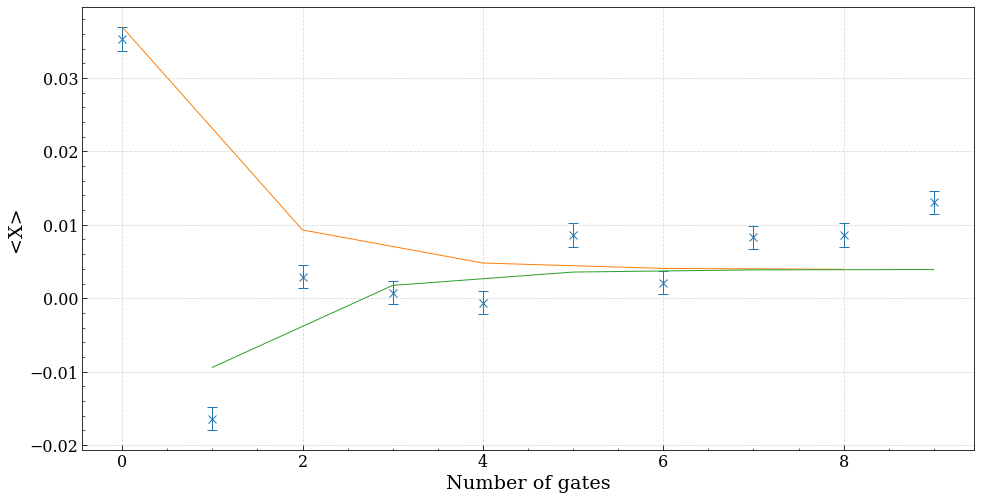

In [164]:
plot_phaseflip_Zgate(nb_gates_range, mean, std, fit)

## Scaling

In [169]:
nb_photons_range = np.array([4.0, 7.0, 10.0])
eps_x_Zgate = np.array([eps_x_Zgate_4_photons, eps_x_Zgate_7_photons, eps_x_Zgate_10_photons])
eps_x_Zgate_std = np.array([eps_x_Zgate_std_4_photons, eps_x_Zgate_std_7_photons, eps_x_Zgate_std_10_photons])
eps_x_spam = np.array([eps_x_spam_4_photons, eps_x_spam_7_photons, eps_x_spam_10_photons])
eps_x_spam_std = np.array([eps_x_spam_std_4_photons, eps_x_spam_std_7_photons, eps_x_spam_std_10_photons])

Text(0, 0.5, '$\\epsilon_X(Z(\\pi))$')

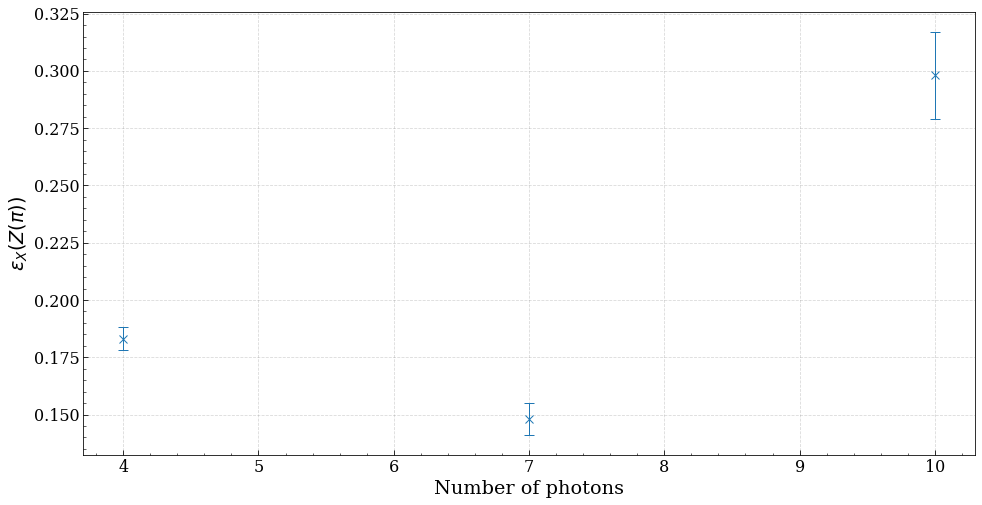

In [170]:
plt.errorbar(nb_photons_range, eps_x_Zgate, yerr=eps_x_Zgate_std, marker='x', markersize=8, capsize=5, linestyle='none')
plt.xlabel('Number of photons')
plt.ylabel('$\epsilon_X(Z(\pi))$')

Text(0, 0.5, '$\\epsilon_X(SPAM)$')

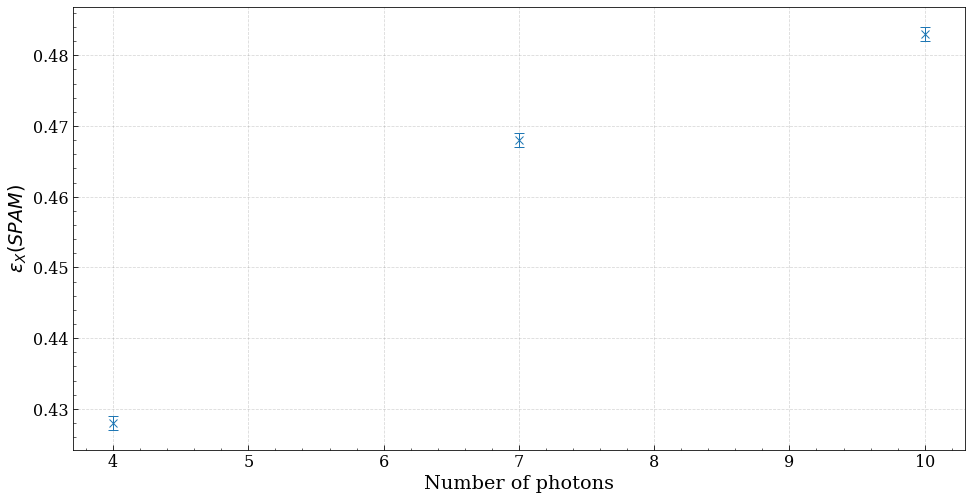

In [171]:
plt.errorbar(nb_photons_range, eps_x_spam, yerr=eps_x_spam_std, marker='x', markersize=8, capsize=5, linestyle='none')
plt.xlabel('Number of photons')
plt.ylabel('$\epsilon_X(SPAM)$')

# Z-gate bit-flip: P0 | Z^n | Mz

A crucial property of cat-qubit gates is  that they should be **bias-preserving**. That is, bit-flips should remain exponentially suppressed during the gate. To characterize the bias-preservingness of the Z-gate, we play the following pulse sequence:

- Prepare $\langle Z \rangle_0 = \pm 1$
- Play a number $n$ of Z-gate
- Measure $\langle Z \rangle_n$

We then fit $\langle Z \rangle_n = \langle Z \rangle_0 C_Z^n$, where $C_Z$ is the loss of contrast of the Pauli observable $Z$ per Z-gate. The bit-flip error probability per Z-gate is then given by:

$$\epsilon_Z = \frac{1 - C_Z}{2}$$

The Z-gate is bias-preserving if $\epsilon_Z$ is suppressed exponentially with the number of photons:

$$\epsilon_Z \propto e^{-\gamma\bar{n}}$$

> Note that we can sometimes observe in this measurement a small bias towards state $|0\rangle$ or $|1\rangle$. This is due to calibrations drift and we're working at improving the stability.

> Also note that, owing to compilation inefficiencies of the first release of the Cloud API, we are limited to play only a few hundred gates (hopefully this limitation will soon be removed!). Therefore, we can only measure $\epsilon_Z$ with acceptable error bars up to $\bar{n}=7$.

## Circuit

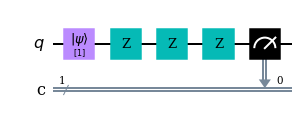

In [7]:
cat_circuit = build_bit_flip_circuit(delay_duration_s=0, add_x=True, add_z=3)
cat_circuit.draw('mpl')

## Helpers

In [8]:
def measure_bitflip_Zgate(nb_photons, nb_gates_range, shots):
    mean = np.zeros((nb_gates_range.size, 2), dtype=float)
    std = np.zeros_like(mean)
    backend = create_boson_4_backend(nb_photons)
    # backend = create_theory_cat_backend(nb_photons)
    for i, nb_gates in enumerate(nb_gates_range):
        for j, add_x in enumerate([True, False]):
            success = False
            while not success:
                try:
                    circuit = build_bit_flip_circuit(delay_duration_s=0, add_z=nb_gates, add_x=add_x)
                    counts = execute(circuit, backend, shots=shots).result().get_counts()
                    m, s = mean_std_Z(counts)
                    mean[i, j] = m
                    std[i, j] = s
                    print(f"nb_photons = {nb_photons} - nb_gates = {nb_gates} - add_x = {add_x} - <Z> = {mean[i, j]:.02e} +- {std[i, j]:.02e}")
                    success = True
                except Exception:
                    traceback.print_exc()
                    sleep(10)
    return mean, std

def fit_bitflip_Zgate(nb_gates_range, mean, std):
    def fun(n, *p):
        C_Zpi = p
        return C_Zpi**n
    x = nb_gates_range
    y = 0.5 * (mean[:, 0] - mean[:, 1])
    sigma = 0.5 * np.sqrt(std[:, 1]**2 + std[:, 0]**2)
    C_Zpi_guess = y[1]
    p0 = [C_Zpi_guess]
    popt, pcov = sp.optimize.curve_fit(fun, x, y, p0=p0, sigma=sigma, absolute_sigma=True)
    eps_z_Zgate = 0.5*(1-popt[0])
    eps_z_Zgate_std = 0.5 * np.sqrt(pcov[0,0])
    fit = fun(nb_gates_range, *popt)
    return fit, eps_z_Zgate, eps_z_Zgate_std

def plot_bitflip_Zgate(nb_gates_range, mean, std, fit):
    plt.errorbar(nb_gates_range, mean[:, 0], yerr=std[:, 0], marker='x', markersize=8, capsize=5, linestyle='none', label='$P_0$')
    plt.errorbar(nb_gates_range, -mean[:, 1], yerr=std[:, 1], marker='x', markersize=8, capsize=5, linestyle='none', label='$P_1$')
    plt.plot(nb_gates_range, fit, label='Fit')
    plt.xlabel('Number of gates')
    plt.ylabel('abs(<Z>)')
    plt.legend()

## 4 photons

In [244]:
nb_photons = 4.0
nb_gates_range = np.arange(0, 200, 20, dtype=int)
shots = 500
mean, std = measure_bitflip_Zgate(nb_photons, nb_gates_range, shots)

[14:16:25] Job 389209ca-2231-4501-8fa2-ed9860cb1f60 finished successfully. Time spent executing on QPU: 765.31ms.
nb_photons = 4.0 - nb_gates = 0 - add_x = True - <Z> = 9.76e-01 +- 1.20e-02
[14:16:36] Job 7b170f0e-e730-4da7-aa74-6e7802a46cb6 finished successfully. Time spent executing on QPU: 731.36ms.
nb_photons = 4.0 - nb_gates = 0 - add_x = False - <Z> = -9.76e-01 +- 1.20e-02
[14:16:57] Job f9241b12-c255-4a3d-a34f-c59bcc52219a finished successfully. Time spent executing on QPU: 1.02s.
nb_photons = 4.0 - nb_gates = 20 - add_x = True - <Z> = 9.44e-01 +- 1.48e-02
[14:17:18] Job aa355ae2-1fca-486c-a058-3febc40653b7 finished successfully. Time spent executing on QPU: 1.07s.
nb_photons = 4.0 - nb_gates = 20 - add_x = False - <Z> = -1.00e+00 +- 1.20e-02
[14:17:58] Job f3a3140a-f405-4678-bb39-23f5ad634d3f finished successfully. Time spent executing on QPU: 1.07s.
nb_photons = 4.0 - nb_gates = 40 - add_x = True - <Z> = 9.28e-01 +- 1.67e-02
[14:18:33] Job 284f0e3b-df7e-4e65-8143-50708d102d58 

In [260]:
fit, eps_z_Zgate, eps_z_Zgate_std = fit_bitflip_Zgate(nb_gates_range, mean, std)
print(f'{nb_photons} photons')
print(f'Z-gate: epsilon_Z = ({eps_z_Zgate:.02e} +- {eps_z_Zgate_std:.02e})')

4.0 photons
Z-gate: epsilon_Z = (4.10e-04 +- 2.37e-05)


In [261]:
eps_z_Zgate_4_photons = eps_z_Zgate
eps_z_Zgate_std_4_photons = eps_z_Zgate_std

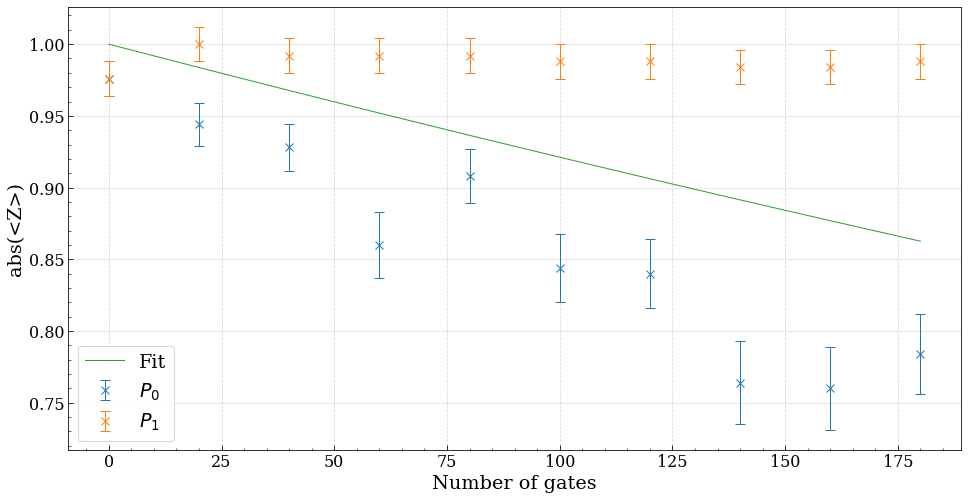

In [262]:
plot_bitflip_Zgate(nb_gates_range, mean, std, fit)

## 5.5 photons

In [26]:
nb_photons = 5.5
nb_gates_range = np.array([0, 100, 200])
shots = 500_000
mean, std = measure_bitflip_Zgate(nb_photons, nb_gates_range, shots)

[15:24:31] Job 6db47054-02f9-4595-ad2b-3f0dcf9ec7ff finished successfully. Time spent executing on QPU: 16.81s.
nb_photons = 5.5 - nb_gates = 0 - add_x = True - <Z> = 9.99e-01 +- 6.83e-05
[15:24:54] Job 1a6f5e0f-0342-43cd-9849-7b884ceabf3e finished successfully. Time spent executing on QPU: 16.86s.
nb_photons = 5.5 - nb_gates = 0 - add_x = False - <Z> = -9.97e-01 +- 1.09e-04
[15:26:30] Job 0c00d65f-d7b1-4eb2-904d-eb7646c190e9 finished successfully. Time spent executing on QPU: 24.67s.
nb_photons = 5.5 - nb_gates = 100 - add_x = True - <Z> = 9.93e-01 +- 1.72e-04
[15:28:03] Job 82c9f2db-62bf-4cd5-b463-2b37c333c258 finished successfully. Time spent executing on QPU: 24.60s.
nb_photons = 5.5 - nb_gates = 100 - add_x = False - <Z> = -9.99e-01 +- 6.13e-05
[15:30:40] Job d5ef090b-3a12-49fe-8648-1257d1c5ed91 finished successfully. Time spent executing on QPU: 33.11s.
nb_photons = 5.5 - nb_gates = 200 - add_x = True - <Z> = 9.88e-01 +- 2.17e-04
[15:33:48] Job 0f995b20-fcca-4087-a535-6faeb689bb5

In [27]:
fit, eps_z_Zgate, eps_z_Zgate_std = fit_bitflip_Zgate(nb_gates_range, mean, std)
print(f'{nb_photons} photons')
print(f'Z-gate: epsilon_Z = ({eps_z_Zgate:.02e} +- {eps_z_Zgate_std:.02e})')

5.5 photons
Z-gate: epsilon_Z = (1.77e-05 +- 2.43e-07)


In [28]:
eps_z_Zgate_5p5_photons = eps_z_Zgate
eps_z_Zgate_std_5p5_photons = eps_z_Zgate_std

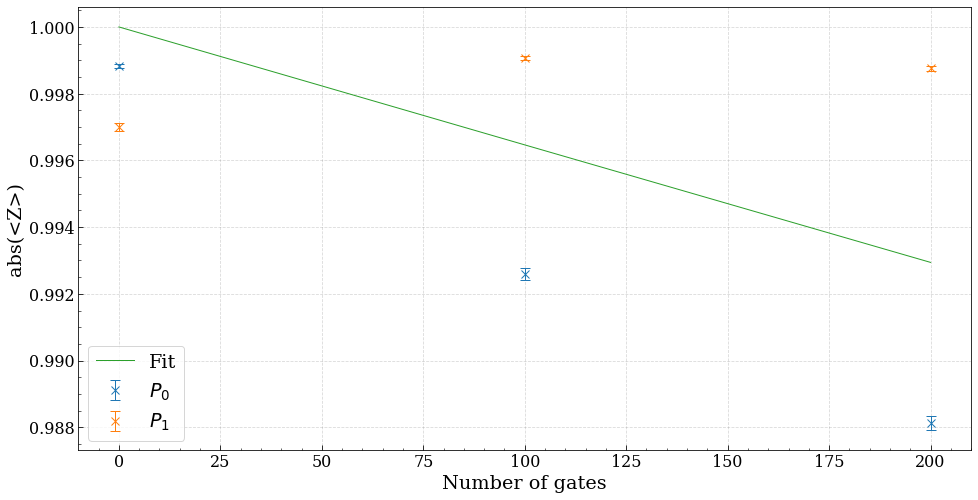

In [29]:
plot_bitflip_Zgate(nb_gates_range, mean, std, fit)

## 7 photons

In [13]:
nb_photons = 7.0
nb_gates_range = np.array([0, 100, 200])
shots = 500_000
mean, std = measure_bitflip_Zgate(nb_photons, nb_gates_range, shots)

[15:05:26] Job 9113b80c-4c2f-4bea-93b4-46e88e6fa4e8 finished successfully. Time spent executing on QPU: 16.97s.
nb_photons = 7.0 - nb_gates = 0 - add_x = True - <Z> = 1.00e+00 +- 2.15e-05
[15:05:49] Job f59ec97c-aaf9-4352-a082-de390a5aeb9d finished successfully. Time spent executing on QPU: 16.85s.
nb_photons = 7.0 - nb_gates = 0 - add_x = False - <Z> = -9.99e-01 +- 4.52e-05
[15:07:34] Job 3377b880-2eb6-408e-a6d0-a73cc1ef8f9f finished successfully. Time spent executing on QPU: 24.57s.
nb_photons = 7.0 - nb_gates = 100 - add_x = True - <Z> = 9.99e-01 +- 6.03e-05
[15:09:06] Job cea8677a-f041-4b0b-bc05-e8dc520d1290 finished successfully. Time spent executing on QPU: 24.65s.
nb_photons = 7.0 - nb_gates = 100 - add_x = False - <Z> = -1.00e+00 +- 2.94e-05
[15:12:02] Job 3a5fd7b5-a3e1-4b89-b7c8-d6a28f8a4353 finished successfully. Time spent executing on QPU: 33.06s.
nb_photons = 7.0 - nb_gates = 200 - add_x = True - <Z> = 9.99e-01 +- 7.54e-05
[15:15:00] Job 22e67b7d-9810-455a-8bf5-61d06786f00

In [14]:
fit, eps_z_Zgate, eps_z_Zgate_std = fit_bitflip_Zgate(nb_gates_range, mean, std)
print(f'{nb_photons} photons')
print(f'Z-gate: epsilon_Z = ({eps_z_Zgate:.02e} +- {eps_z_Zgate_std:.02e})')

7.0 photons
Z-gate: epsilon_Z = (2.37e-06 +- 8.89e-08)


In [15]:
eps_z_Zgate_7_photons = eps_z_Zgate
eps_z_Zgate_std_7_photons = eps_z_Zgate_std

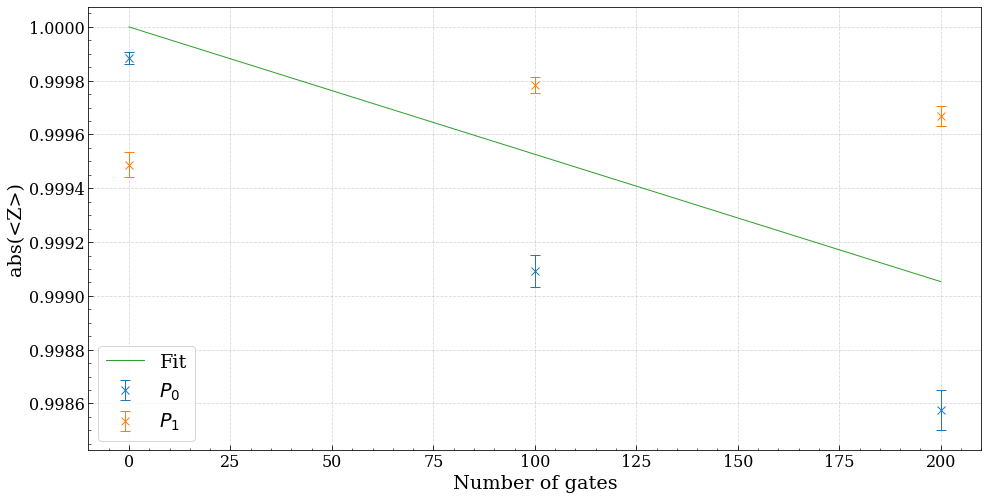

In [16]:
plot_bitflip_Zgate(nb_gates_range, mean, std, fit)

## Scaling

Gathering the results of the previous sections, we plot the scaling of the bit-flip error probability per Z-gate $\epsilon_Z$ with $\bar{n}$ and fit it with an exponential function $\exp(\gamma \bar{n})$.

The scaling factor $\gamma$ fitted on $\epsilon_Z$ has almost that fitted on $T_Z$. That is, bit-flips during the Z-gate and idling are similar.

In [30]:
nb_photons_range = np.array([4.0, 5.5, 7.0])
eps_z_Zgate = np.array([eps_z_Zgate_4_photons, eps_z_Zgate_5p5_photons, eps_z_Zgate_7_photons])
eps_z_Zgate_std = np.array([eps_z_Zgate_std_4_photons, eps_z_Zgate_std_5p5_photons, eps_z_Zgate_std_7_photons])

In [33]:
def fun(nbar, *p):
    A, gamma = p
    return A * np.exp(gamma * nbar)
x = nb_photons_range
y = eps_z_Zgate
sigma = eps_z_Zgate_std
gamma_guess = np.log(y[0] / y[1]) / (x[0] - x[1])
A_guess = y[0] / np.exp(gamma_guess * x[0])
p0 = [A_guess, gamma_guess]
popt, pcov = sp.optimize.curve_fit(fun, x, y, p0=p0, sigma=sigma, absolute_sigma=True)

Text(0.5, 1.0, '$\\gamma=(-1.44\\pm0.03)$')

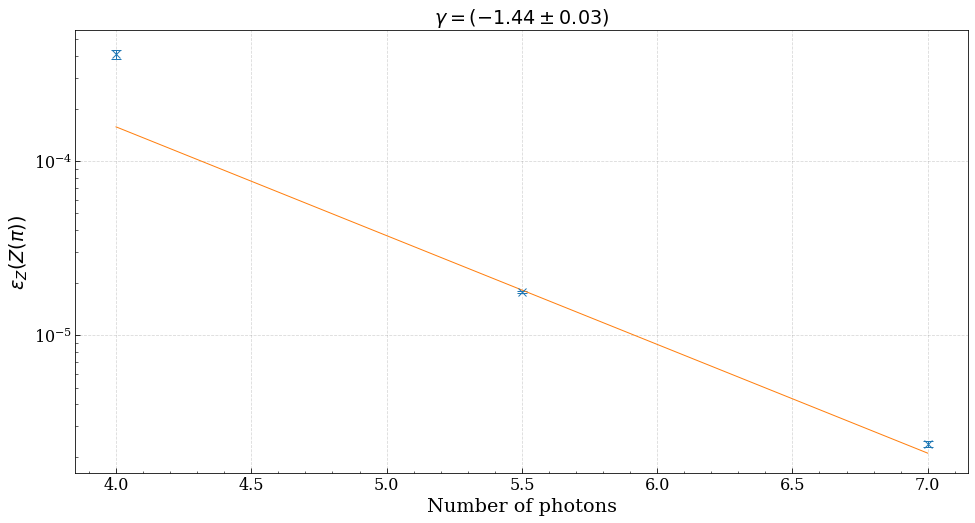

In [36]:
plt.errorbar(nb_photons_range, eps_z_Zgate, yerr=eps_z_Zgate_std, marker='x', markersize=8, capsize=5, linestyle='none')
plt.plot(nb_photons_range, fun(nb_photons_range, *popt))
plt.yscale('log')
plt.xlabel('Number of photons')
plt.ylabel('$\epsilon_Z(Z(\pi))$')
plt.title(f'$\gamma=({popt[1]:.02f}\pm{np.sqrt(pcov[1,1]):.02f})$')